## CS536: Decision Trees
#### Done by - Vedant Choudhary, vc389
Let ${(X_1, Y_1),(X_2, Y_2), . . . ,(X_m, Y_m)}$ denote a data set, where $X_i$ represents a vector of k (binary) feature values,
and $Y_i$ is a corresponding binary class or label that we will need to learn to be able to predict from the X-values.
We generate data via the following scheme, defining a distribution for our data set: Let $X = (X_1, X_2, X_3, . . . , X_k)$
be a vector of binary values, satisfying the following
- $X_1 = 1$ with probability 1/2, $X_1 = 0$ with probability 1/2
- For i = 2, . . . , k, $X_i = X_{i−1}$ with probability 3/4, and $X_i = 1 − X_{i−1}$ with probability 1/4.
In this way, the first feature value is uniformly random, but every successive feature is strongly correlated with the
value of the feature before it. We can then define Y to be a function of X as
$$Y = X_1 if w_2X_2 + w_3X_3 + . . . + w_kX_k ≥ 1/2$$
$$Y = 1 − X_1 else$$

In other words, if the ‘weighted average’ of $X_2, . . . X_k$ tilts high, Y will agree with $X_1$; if the weighted average of
$X_2, . . . , X_k$ tilts low, Y will disagree with $X_1$. Take the weights to be defined by $w_i = \frac{0.9^i}{0.9^2 + 0.9^3 + ... + 0.9^k}$

#### 1. For a given value of k, m, (number of features, number of data points), write a function to generate a training data set based on the above scheme.
__Solution:__ The value of k and m are declared globally in this program. The user can change it by going to [Data Creation](#data_creation). For general tree building, k is set to 4, and m is set to 30.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm

%matplotlib inline

<a id = "data_creation">Combining all the sub datasets to a final dataframe</a>

In [2]:
# Creating X (feature) vectors for the data
def create_data(k, m):
    X = [[0]*k for i in range(m)]
    for i in range(m):
        X[i][0] = int(np.random.choice(2, size=1))
        for j in range(1, k):
            temp = np.random.choice(2, 1, p=[0.25,0.75])
            if temp == 1:
                X[i][j] = X[i][j-1]
            else:
                X[i][j] = 1 - X[i][j-1]
    return X

# Creating weights for the data
def create_weights(k):
    div = 0
    weight = [0]*(k+1)
    for i in range(2, k+1):
        div += 0.9**i
    for i in range(1, k+1):
        weight[i] = (0.9**i)/div
        
    return weight[1:]
 
# Creating target column for the data
def create_y(X, w, k, m):
    y = []
    for i in range(m):
        val = np.dot(X[i][1:], w[1:].T)
#         print(val)
        if val < 0.5:
            y.append(1 - X[i][0])
        else:
            y.append(X[i][0])
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m):
    X = np.asarray(create_data(k, m))
    w = np.asarray(create_weights(k))
    y = np.asarray(create_y(X, w, k, m)).reshape((m,1))

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [15]:
# Global variables, k - number of features, m - sample size, epsilon - a very small value (e-16) used to avoid divide by zero errors
k, m = 10, 30
epsilon = np.finfo(float).eps

train_data = create_dataset(k, m)
train_data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,1,1,1,1,1,1,0,0,0,1,1
1,0,1,1,0,1,1,1,1,0,0,0
2,0,0,0,1,1,0,0,1,0,0,1
3,1,1,1,1,0,1,1,1,1,1,1
4,0,0,1,0,0,1,1,1,1,1,0
5,0,0,0,0,0,0,0,1,1,1,1
6,1,1,0,0,1,0,0,0,1,1,0
7,1,1,1,0,0,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,1
9,1,1,1,1,1,1,1,1,1,1,1


#### 2. Given a data set, write a function to fit a decision tree to that data based on splitting the variables by maximizing the information gain. Additionally, return the training error of this tree on the data set, $err_{train}(\hat{f})$. It may be useful to have a function that takes a data set and a variable, and returns the data set partitioned based on the values of that variable
__Solution:__ A class has been made for the decision tree. The functions enlisted in the class are:
1. entropy
2. conditional_entropy
3. gini_index_calculation
4. gini_index_split
5. information_gain_split
6. get_subset
7. build_tree
8. predict
9. fit
10. generate_data_and_typical_error
For more information related to the functions, check the comments written above each function

In [122]:
# Class for Decision Tree
class DecisionTree(): 
    '''
    Entropy function calculates the entropy of unique values in the target data i.e. entropy for 0 and 1
    Input - dataset
    Return - Entropy value for target
    '''
    def entropy(self, data):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
        entropy_y = 0
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
        
        for val in target_vals:
            p = data[target].value_counts()[val]/len(data[target])
            entropy_y += -p*np.log2(p)
        return entropy_y
    
    '''
    Calculates the conditional entropy of the target variable w.r.t to the features i.e. H(Y|X)
    Input - dataset, feature
    Return - Conditional entropy    
    '''
    def conditional_entropy(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1]
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        cond_entropy_y = 0
        
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            entropy = 0
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + epsilon)
                entropy += -(e)*np.log2(e + epsilon)
            cond_entropy_y += -(denom/len(data))*entropy
            
        return abs(cond_entropy_y)
    
    '''
    Calculates the impurity of a feature based on gini index
    Input - dataset, feature
    Return - gini_values
    '''
    def gini_index_calculation(self, data, feature):
#         Fetching the last column key (target column)
        target = data.keys()[-1] 
#         Listing the unique values of target variable, here it is 0 and 1
        target_vals = data[target].unique()
#         Listing the unique values of current feature variable, here it is 0 and 1
        feature_vals = data[feature].unique()
        weighted_gini = 0
#         Going over the unique values of current feature, and calculation the cross-entropy
        for fval in feature_vals:
            gini = 1
            for tval in target_vals:
#                 num calculates the number of data points that satisfy the feature and target values. Example - data points which have y as 0 and x as 0
                num = len(data[feature][data[feature] == fval][data[target] == tval])
#                 denom calculates the total number of data points satisfying feature = 0 or 1 (depends on fval)
                denom = len(data[feature][data[feature] == fval])
                e = num/(denom + epsilon) 
                gini -= e**2
            weighted_gini += (denom/len(data))*gini
        
        return weighted_gini                
    
    '''
    Splits on least gini inde value
    Input - dataset
    Return - min value of gini index feature
    '''
    def gini_index_split(self, data):
        gini_index = []
#         For every feature except the last column(y) in the dataset
        for key in data.keys()[:-1]:
            gini_index.append(self.gini_index_calculation(data, key))
            
        return data.keys()[:-1][np.argmin(gini_index)]
    
    '''
    Calculates information gain value
    Input - dataset
    Return - max value of information gain feature
    '''
    def information_gain_split(self, data):
        IG = []
#         For every feature except the last column(y) in the dataset
        for key in data.keys()[:-1]:
            IG.append(self.entropy(data) - self.conditional_entropy(data, key))
        
        return data.keys()[:-1][np.argmax(IG)]
    
    '''
    Trims down the dataset as per the information gain node. Helps in building tree
    Input - dataset, node(which is the best split feature), val is either 0 or 1
    Return - trimmed dataset
    '''
    def get_subset(self, data, node, value):
        return data[data[node] == value].reset_index(drop=True)
                        
    '''
    Builds the decision tree based on functions written above. It is a recursive function till leaf nodes found
    Input - dataset
    Return - the built decision tree, in a dictionary like format
    '''
    def build_tree(self, data, method, tree=None):
        target = data.keys()[-1]
        if method == "information gain":
            best_split = self.information_gain_split(data)
        elif method == "gini index":
            best_split = self.gini_index_split(data)
        feature_vals = data[best_split].unique()
        
        if tree is None:
            tree = {}
            tree[best_split] = {}
        
        for val in feature_vals:
            subset = self.get_subset(data, best_split, val)
            target_val, target_counts = np.unique(subset[subset.keys()[-1]], return_counts=True)
            if len(target_counts) == 1:
                tree[best_split][val] = target_val[0]
            else:
                tree[best_split][val] = self.build_tree(subset, method=method)        
        
        return tree      
        
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector, decision tree
    Return - predicted value
    '''
    def predict(self, instance_data, tree):
        for node in tree.keys():
            value = instance_data[node]
            tree = tree[node][value]
            prediction = 0
            
            if type(tree) is dict:
                prediction = self.predict(instance_data, tree)
            else:
                prediction = tree
                break
        
        return prediction
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data, tree):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i], tree)
            if prediction != data.iloc[i][-1]:
                error += 1
        return error/len(data)    
    
    '''
    Generates multiple datasets and finds error on those datasets
    Input - Built decision tree, feature values, sample size of dataset
    Return - typical error
    '''
    def generate_data_and_typical_error(self, tree, k, m):
        typical_error = 0
        for i in tqdm(range(200)):
            data = create_dataset(k, m)
            typical_error += self.fit(data, tree)

        typical_error = typical_error/200
        return typical_error

#### 3. For k = 4 and m = 30, generate data and fit a decision tree to it. Does the ordering of the variables in the decision tree make sense, based on the function that defines Y ? Why or why not? Draw the tree
__Solution:__ We see that the value of target variable "y" depends heavily on $X_1$ because of the way the mapping function has been created. Values of y are either $X_1$ or $1-X_1$. Due to this, intuitively and empirically we usually see $X_1$ in the upper layers of the decision tree. For other variables such as $X_2, X_3..X_k$ we cannot be sure where they will end up in the decision tree. 

One more thing which supports the above answer is how weight variables are generated. Going by the function, $w_2$ has highest value, which might lead us to believe that values of $X_2$ should have highest decision value for Y, but that is not shown in the decision trees, as often $X_2$ comes down the tree structure.


Here, the decision tree is drawn in a dictionary-kind of manner. I have also attached an image, which will help one map this structure to a more conventional graph-based structure.

In [123]:
dt = DecisionTree()

In [124]:
tree = dt.build_tree(train_data, "information gain")
pprint.pprint(tree)

{'X9': {0: {'X1': {0: {'X3': {0: 1, 1: {'X5': {0: 1, 1: 0}}}},
                   1: {'X6': {0: 0, 1: 1}}}},
        1: {'X1': {0: {'X6': {0: 1, 1: 0}}, 1: {'X3': {0: 0, 1: 1}}}}}}


In [91]:
error = dt.fit(train_data, tree)
error

0.0

#### 4. Write a function that takes a decision tree and estimates its typical error on this data $err(\hat{f})$; i.e., generate a lot of data according to the above scheme, and find the average error rate of this tree over that data.

In [92]:
typical_error = dt.generate_data_and_typical_error(tree, k, m)
typical_error

100%|██████████| 200/200 [00:01<00:00, 100.10it/s]


0.05633333333333324

#### 5. For k = 10, estimate the value of $|err_{train}(\hat{f}) − err(\hat{f})|$ for a given m by repeatedly generating data sets, fitting trees to those data sets, and estimating the true and training error. Do this for multiple m, and graph this difference as a function of m. What can you say about the marginal value of additional training data?
__Solution:__ 
1. The plot is shown in below cells.
2. Marginal value keeps on decreasing as m increases. Why this makes sense is because, as we increase the sample size (m), we are getting to see more and more of the actual data represented by the probabilities of data creation. For k=10, we can say $2^{10}$ samples will fully represent the data. So, as we increase the samples, the marginal value should keep on decreasing as we are getting to see more of how actual data might look like, allowing the model to be trained on a better representative of the data. Ideally, marginal value should go towards zero as samples become much larger than 1024. 

In [93]:
# This function generates data depending on different values of m
def generate_data_varied_m(method):
    k = 10
    m = list(range(10, 200, 10))
    errors = []
    for sample_size in m:
        train_data = create_dataset(k, sample_size)
        dt = DecisionTree()
        tree = dt.build_tree(train_data, method)
        train_error = dt.fit(train_data, tree)
        typical_error = dt.generate_data_and_typical_error(tree, k, sample_size)
        errors.append(abs(train_error - typical_error))
    plt.plot(m, errors)
    plt.xlabel("Value of m (sample size)")
    plt.ylabel("Abs. difference between training and true error")
    plt.title("Error difference as a function of m")
    plt.show()
    return errors, m

100%|██████████| 200/200 [00:21<00:00,  8.80it/s]


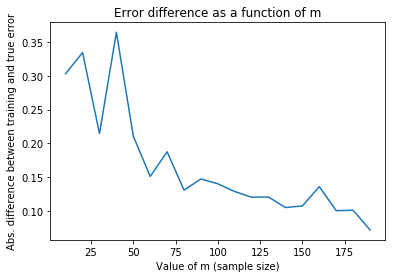

In [94]:
errors_ig, x_axis = generate_data_varied_m("information gain")

#### 6. Design an alternative metric for splitting the data, not based on information content / information gain. Repeat the computation from (5) above for your metric, and compare the performance of your trees vs the ID3 trees
__Solution:__ An alternative metric provided here is __Gini Index__. It is a very popular cost function to calculate splits in CART (Classification and Regression Trees). 

Gini index calculates the impurity(purity) of the split. It gives an idea of how good a split is based on how mixed the classes are in the two groups created by the split. A perfect separation will result in a Gini score of 0(best) and the worst case will be when the split has equal probability of the class i.e. 50/50 (in binary).

It's calculation is very similar to information content/gain method. We basically calculate the probability of each unique target class value depending on the value of a feature. To estimate the probability, we count the observations. 
$$GiniIndex = 1 - \sum_{t=0}^{1}{P_{t}^2}$$
On comparing this metric with ID3, we observe that both are pretty similar and exhibit similar kind of [errors](#comparison).

In [95]:
tree_gini = dt.build_tree(train_data, "gini index")
pprint.pprint(tree_gini)

{'X3': {0: {'X1': {0: 1, 1: {'X4': {0: 0, 1: 1}}}},
        1: {'X1': {0: 0, 1: {'X2': {0: {'X4': {0: 0, 1: 1}}, 1: 1}}}}}}


In [96]:
error = dt.fit(train_data, tree_gini)
error

0.0

In [97]:
typical_error = dt.generate_data_and_typical_error(tree_gini, k, m)
typical_error

100%|██████████| 200/200 [00:02<00:00, 97.02it/s] 


0.05766666666666656

100%|██████████| 200/200 [00:23<00:00,  7.70it/s]


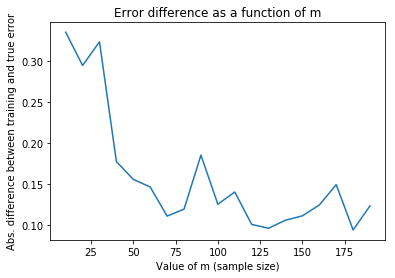

In [98]:
errors_gi, x_axis = generate_data_varied_m("gini index")

<a id="comparison">Comparison of both the algorithms</a>

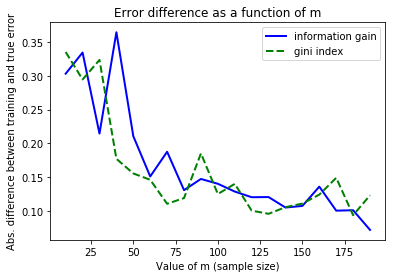

In [99]:
plt.plot(x_axis, errors_ig, marker='', color='blue', linewidth=2, label="information gain")
plt.plot(x_axis, errors_gi, marker='', color='green', linewidth=2, linestyle='dashed', label="gini index")
plt.xlabel("Value of m (sample size)")
plt.ylabel("Abs. difference between training and true error")
plt.title("Error difference as a function of m")
plt.legend()
plt.show()